In [1]:
import numpy as np
import io
import os
import pandas as pd
from scipy.stats import chi2_contingency
from scipy.stats import hypergeom
from scipy.stats import fisher_exact
import bdsg
import copy
import re 
import matplotlib.pyplot as plt

# Tests

In [ ]:
### test exact fisher ###
table = np.array([[6, 2], [1, 4]])
M = table.sum()
n = table[0].sum()
N = table[:, 0].sum()
start, end = hypergeom.support(M, n, N)
hypergeom.pmf(np.arange(start, end + 1), M, n, N)
np.array([0.01631702, 0.16317016, 0.40792541, 0.32634033, 0.08158508, 0.004662])
res = fisher_exact(table, alternative='two-sided')
print("fisher : ", res.pvalue)

# From VCF file
## read vcf, create data frames

In [ ]:
# on va essayer de faire un giga tableau qui recense tous les chemins possibles -> OK (pour un éch mais normalement c'est les mêmes chemins possibles)
# une fois qu'on aura fait ce giga tableau, on va essayer de le transformer en giga matrice qui compte pour 1 éch les chemins pris -> OK
# une fois que ce sera fait on pourra transformer la giga matrice en giga table de contingence (?) qui recense la même chose mais pour tous les échantillons -> OK (dataframe)

In [ ]:
# fonctions annexes pour créer le df qui contient les infos après avoir parse tous les vcf

In [2]:
# read ONE vcf file

def create_vcf_df(path):
    with open(path, 'r') as f:
        lines = [l for l in f if not l.startswith('##')]
    return pd.read_csv(
        io.StringIO(''.join(lines)),
        dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str,
               'QUAL': str, 'FILTER': str, 'INFO': str},
        sep='\t'
    ).rename(columns={'#CHROM': 'CHROM'})

# verification de la fonction read_vcf 
vcf1_df = create_vcf_df("/home/yboulkaid/Documents/sample_data/pgtest.data/calls/samp_g0_0.vcf")
vcf1_df

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE
0,ref,450,>1>4,T,G,133.927,PASS,"AT=>1>2>4,>1>3>4;DP=46",GT:DP:AD:GL:GQ:GP:XD:MAD,"0/0:46:46,0:-2.378747,-15.294357,-107.194421:1..."
1,ref,578,>4>9,TTTGCGGGCCGTCAAGATGAACTGGTGCCTGTAGGATTATGTCCTC...,TTTGCGGGCCGTCAAGATGAACTGGTGCCTGTAGGATTATGTCCTC...,14.6171,PASS,"AT=>4>5>7>8>9,>4>5>6>8>9;DP=50",GT:DP:AD:GL:GQ:GP:XD:MAD,"1/0:50:25,25:-3.306431,-2.422690,-3.306431:16:..."
2,ref,1118,>9>12,A,G,177.783,PASS,"AT=>9>11>12,>9>10>12;DP=61",GT:DP:AD:GL:GQ:GP:XD:MAD,"0/0:61:61,0:-2.701171,-20.002352,-141.869830:1..."
3,ref,1340,>12>14,GATCGGACTTCTTAACGGGTTCCTCACGTAGCGATCTCTACGGGAA...,G,116.981,PASS,"AT=>12>13>14,>12>14;DP=47",GT:DP:AD:GL:GQ:GP:XD:MAD,"0/0:47:46,1:-2.770745,-13.991746,-90.540504:11..."
4,ref,1529,>14>19,C,CCCGATCTATGTCGAGGCTTTCGGGCAGGGCCGCTATTAACATCGT...,175.5,PASS,"AT=>14>19,>14>15>17>18>19,>14>15>16>18>19;DP=60",GT:DP:AD:GL:GQ:GP:XD:MAD,"0/0:60:60,0,0:-2.835631,-19.908524,-19.908524,..."
...,...,...,...,...,...,...,...,...,...,...
95,ref,27003,>489>492,C,T,411.605,PASS,"AT=>489>490>492,>489>491>492;DP=43",GT:DP:AD:GL:GQ:GP:XD:MAD,"1/0:43:20,23:-43.061833,-2.378411,-35.907321:2..."
96,ref,27134,>492>497,A,ATACACTAGACGCCCGGGATGTACATATCGTGACTCGTTCCTAGTC...,145.789,PASS,"AT=>492>497,>492>493>495>496>497,>492>493>494>...",GT:DP:AD:GL:GQ:GP:XD:MAD,"0/0:50:50,0,0:-2.439843,-16.541658,-16.541658,..."
97,ref,27275,>497>502,TGCAATAGTTTGCTCGTGGTCAGTATTTTCGGTATAAAACAGAGTT...,"T,TGCAATAGTTTGCTCGTGGTCAGTATTTTCGGTATAAAACAGAG...",371.786,PASS,"AT=>497>498>500>501>502,>497>502,>497>498>499>...",GT:DP:AD:GL:GQ:GP:XD:MAD,"1/2:52:2,24,27:-39.603567,-3.504039,-35.913027..."
98,ref,27745,>502>507,CGGACATGTAGCAGGACTCCTTATAGTTAATGTTCACTATTTAAAG...,CGGACATGTAGCAGGACTCCTTATAGTTAATGTTCACTATTTAAAG...,122.081,PASS,"AT=>502>503>504>506>507,>502>503>505>506>507,>...",GT:DP:AD:GL:GQ:GP:XD:MAD,"0/0:42:42,0,0:-2.420888,-14.151905,-14.151905,..."


In [3]:
# read all vcf files and store them in a list

all_vcf = os.listdir("/home/yboulkaid/Documents/sample_data/pgtest.data/calls/")
g0_vcf =  []
g1_vcf = []
for i in all_vcf:
    if 'g0' in i:
        g0_vcf.append(i)
    elif 'g1' in i:
        g1_vcf.append(i)
all_vcf_df = [create_vcf_df("/home/yboulkaid/Documents/sample_data/pgtest.data/calls/"+i) for i in all_vcf]
g0_vcf_df  = [create_vcf_df("/home/yboulkaid/Documents/sample_data/pgtest.data/calls/"+i) for i in g0_vcf ]
g1_vcf_df  = [create_vcf_df("/home/yboulkaid/Documents/sample_data/pgtest.data/calls/"+i) for i in g1_vcf ]

In [4]:
def chemins(which_vcf_df):    
    chemins_possibles = []
    for i in range(len(which_vcf_df["INFO"])):
        text = which_vcf_df["INFO"][i]
        m = re.search('AT=>(.+?);DP', text)
        if m:
            found = m.group(1)
        chemins_possibles.append(found)
        
    for i in range(len(chemins_possibles)):
        chemins_possibles[i] = chemins_possibles[i].split(',')
        
    ########################################################################
    chemins_pris = []
    for i in which_vcf_df["SAMPLE"]:
        found = i[0:3]
        chemins_pris.append(found)
    
    for i in range(len(chemins_pris)):
        chemins_pris[i] = chemins_pris[i].split('/')
        for j in range(len(chemins_pris[i])):
            chemins_pris[i][j] = int(chemins_pris[i][j])
            
    ########################################################################
    chemins_combines = copy.deepcopy(chemins_pris)
    
    for i in range(len(chemins_pris)):
        chemins_combines[i][0] = chemins_possibles[i][chemins_pris[i][0]]
        chemins_combines[i][1] = chemins_possibles[i][chemins_pris[i][1]]
        
    ''' cas simple pour comprendre
    print(chemins_pris[0])
    chemins_pris[0][0] = chemins_possibles[0][chemins_pris[0][0]]
    chemins_pris[0][1] = chemins_possibles[0][chemins_pris[0][1]]
    print(chemins_pris[0])'''
    
    chemins_possibles = sum(chemins_possibles, [])
    chemins_pris = sum(chemins_pris, [])
    chemins_combines = sum(chemins_combines, [])
    
    return chemins_possibles, chemins_pris, chemins_combines

In [ ]:
chemins_possibles1, chemins_pris1, chemins_combines1 = chemins(vcf1_df)
print('========== possibles ==========')
print(chemins_possibles1[0:5])
print('============ pris =============')
print(chemins_pris1[0:5])
print('========== combinés ===========')
print(chemins_combines1[0:5])

In [ ]:
'''def chemins(vcf_df):
    chemins_possibles = []
    for i in range(len(vcf_df["INFO"])):
        text = vcf_df["INFO"][i]
        m = re.search('AT=>(.+?);DP', text)
        if m:
            found = m.group(1)
        chemins_possibles.append(found)
        
    for i in range(len(chemins_possibles)):
        chemins_possibles[i] = chemins_possibles[i].split(',')
        
    ########################################################################
    chemins_pris = []
    for i in vcf_df["SAMPLE"]:
        found = i[0:3]
        chemins_pris.append(found)
    
    for i in range(len(chemins_pris)):
        chemins_pris[i] = chemins_pris[i].split('/')
        for j in range(len(chemins_pris[i])):
            chemins_pris[i][j] = int(chemins_pris[i][j])
            
    ########################################################################
    chemins_combines = copy.deepcopy(chemins_pris)
    
    for i in range(len(chemins_pris)):
        chemins_combines[i][0] = chemins_possibles[i][chemins_pris[i][0]]
        chemins_combines[i][1] = chemins_possibles[i][chemins_pris[i][1]]
        
    chemins_possibles = sum(chemins_possibles, [])
    chemins_pris = sum(chemins_pris, [])
    chemins_combines = sum(chemins_combines, [])
    #chemins_finaux = [[i,chemins_combines.count(i)] for i in set(chemins_combines)]
    
    return chemins_possibles, chemins_pris, chemins_combines, chemins_finaux

path = "/home/yboulkaid/Documents/sample_data/pgtest.data/calls/"
all_vcf_df = [create_vcf_df(path+i) for i in all_vcf]

chemins_possibles = [chemins(i)[0] for i in all_vcf_df]
# chemins_possibles = sum(chemins_possibles, [])
# chemins_possibles = list(set(chemins_possibles))
chemins_pris = [chemins(i)[1] for i in all_vcf_df]
chemins_combines = [chemins(i)[2] for i in all_vcf_df]
chemins_finaux = [chemins(i)[3] for i in all_vcf_df]

''''''chemins_combines = sum(chemins_combines, [])
chemins_finaux = [[i,chemins_combines.count(i)] for i in set(chemins_combines)]''' '''''';

In [5]:
vcf2_df = create_vcf_df("/home/yboulkaid/Documents/sample_data/pgtest.data/calls/samp_g0_1.vcf")
vcf3_df = create_vcf_df("/home/yboulkaid/Documents/sample_data/pgtest.data/calls/samp_g1_1.vcf")

# je l'utulise même pas au final (mziana fih tfo)
def chemins_finaux(vcf_df_list):
    chemins_finaux = []
    for i in range(len(vcf_df_list)):
        chemins_aux = []
        chemins_possibles, chemins_pris, chemins_combines = chemins(vcf_df_list[i])
        for j in set(chemins_combines):
            chemins_aux.append([j,chemins_combines.count(j)])
        chemins_finaux.append(chemins_aux)
    return chemins_finaux

In [6]:
def create_df(which_vcf_list):
    # chem_fin = chemins_finaux(which_vcf_list)
    df = pd.DataFrame(columns=['snarl index', 'snarl', 'times taken','index provisoire'])
    # df['times taken'] = 0 # je sais vraiment pas pourquoi ça marche plus ce machin 
    #df = df.assign(times_taken = 0)

    chemins_possibles = [chemins(i)[0] for i in all_vcf_df]
    chemins_possibles = sum(chemins_possibles, [])
    chemins_possibles = list(set(chemins_possibles))
    for i in range(len(chemins_possibles)):
        df.loc[i, 'times taken'] = 0

    df['snarl'] = chemins_possibles
    
    for i in which_vcf_list:
        chemins_combines = chemins(i)[2]
        combine_count = list((x,chemins_combines.count(x)) for x in set(chemins_combines))
        for j in range(len(combine_count)):
            for k in range(len(df['snarl'])):
                if combine_count[j][0] == str(df['snarl'][k]):
                    df.loc[k, "times taken"] += combine_count[j][1]
    
    # fill 'snarl index' column
    for i in range(len(df['snarl index'])):
        if df['snarl'][i][0] == '>':
            S = re.search('>(.+?)>', df['snarl'][i])
            if S:
                s = S.group(1)
            E = re.search('.+>(.*)', df['snarl'][i])
            if E:
                e = E.group(1)
            df.loc[i, "snarl index"] = s + '>' + e  
            df.loc[i, "index provisoire"] = int(s)
        else:
            S = re.search('(.+?)>', df['snarl'][i])
            if S:
                s = S.group(1)
            E = re.search('.+>(.*)', df['snarl'][i])
            if E:
                e = E.group(1)
            df.loc[i, "snarl index"] = s + '>' + e
            df.loc[i, "index provisoire"] = int(s)
    
    #df.set_index('snarl index', inplace=True, drop=True)
    df.set_index('index provisoire', inplace=True, drop=True)
    df.sort_index(inplace=True)
    df.reset_index()
    df.set_index('snarl index', inplace=True, drop=True)
    return df

In [7]:
snarl_df = create_df(all_vcf_df)
snarl_df

,snarl,times taken
snarl index,,
1>4,1>2>4,51
1>4,>1>3>4,69
4>9,4>5>7>8>9,53
4>9,>4>5>6>8>9,59
4>9,>4>9,8
...,...,...
502>507,>502>507,3
502>507,>502>503>505>506>507,28
507>512,>507>508>510>511>512,11


In [8]:
# group0 df
g0_df = create_df(g0_vcf_df)
g0_df

,snarl,times taken
snarl index,,
1>4,1>2>4,27
1>4,>1>3>4,33
4>9,4>5>7>8>9,23
4>9,>4>5>6>8>9,32
4>9,>4>9,5
...,...,...
502>507,>502>507,1
502>507,>502>503>505>506>507,14
507>512,>507>508>510>511>512,6


In [9]:
# group1 df
g1_df = create_df(g1_vcf_df)
g1_df

,snarl,times taken
snarl index,,
1>4,1>2>4,24
1>4,>1>3>4,36
4>9,4>5>7>8>9,30
4>9,>4>5>6>8>9,27
4>9,>4>9,3
...,...,...
502>507,>502>507,2
502>507,>502>503>505>506>507,14
507>512,>507>508>510>511>512,5


## pvaleurs aaaaah

In [10]:
# mtn on utilise g0_df et g1_df pour créer des tables de contingences (en précisant pour quel snarl on veut créer la table)
# old
def table_contingence(which_snarl):
    n = snarl_df.index.value_counts()[which_snarl]
    chem = []
    for i in range(n):
        chem.append(g0_df.loc[which_snarl]['snarl'].iloc[i])
        #thing.append(g0_df.loc[which_snarl]['snarl'][i])
        # corpus_df.loc['it'][1]
    df2 = pd.DataFrame(columns=['g0', 'g1'], index=chem)
    for i in range(len(chem)):
        df2.at[chem[i], 'g1'] = g1_df.loc[which_snarl]['times taken'].iloc[i]
        df2.at[chem[i], 'g0'] = g0_df.loc[which_snarl]['times taken'].iloc[i]
    return df2
    
def chi2(table):
    return chi2_contingency(table).pvalue

In [11]:
pval_list = []
deux_zero_dans_contingence_snarl = [] 
for i in snarl_df.index.unique():
    table = table_contingence(i)
    if ((table['g0'] == 0) & (table['g1'] == 0)).any():
        deux_zero_dans_contingence_snarl.append(i)
        #table =  table.drop(table['g0' == any].any == 0 and table['g1'].any == 0)
        #table = table.drop(table[<some boolean condition>].index)
    else:
        pval_list.append([chi2(table), i])

print(len(deux_zero_dans_contingence_snarl))
print(deux_zero_dans_contingence_snarl)
print(len(pval_list))

12
['79>84', '136>147', '152>154', '159>170', '204>239', '293>307', '315>329', '351>380', '380>403', '403>417', '427>438', '452>466']
88


In [ ]:
pval_list = []
deux_zero_dans_contingence_snarl = [] 
tables_deux_zeros = []
for i in snarl_df.index.unique():
    table = table_contingence(i)
    for j in range(len(table)):
        if table['g0'].iloc[j] == 0 and table['g1'].iloc[j] == 0:
            deux_zero_dans_contingence_snarl.append(i)
            tables_deux_zeros.append([table.drop(table.index[j]), i])
            #print(table.index[j])
            #table.drop(table.index[j])
for i in snarl_df.index.unique():
    if i not in deux_zero_dans_contingence_snarl:
        pval_list.append([chi2(table), i])
        
deux_zero_dans_contingence_snarl = list(set(deux_zero_dans_contingence_snarl))
#tables_deux_zeros = list(set(tables_deux_zeros))


In [65]:
pval_list = []
deux_zero_dans_contingence_snarl = [] 
tables_deux_zeros = []
index_temp = []
for i in snarl_df.index.unique():
    table = table_contingence(i)
    l = len(table)
    table_to_modify = table.copy(deep = True)
    ctr = 0
    for j in range(l):
        if table['g0'].iloc[j] == 0 and table['g1'].iloc[j] == 0:
            ctr += 1
            deux_zero_dans_contingence_snarl.append(i)
            table_to_modify = table_to_modify.drop(table_to_modify.index[j-ctr])
        if not table_to_modify.equals(table):
            print(i)
            tables_deux_zeros.append([table_to_modify, i])
            #print(table.index[j])
            #table.drop(table.index[j])
            
for i in snarl_df.index.unique():
    if i not in deux_zero_dans_contingence_snarl:
        pval_list.append([chi2(table), i])
        


deux_zero_dans_contingence_snarl = list(set(deux_zero_dans_contingence_snarl))
#tables_deux_zeros = list(set(tables_deux_zeros))

print(len(deux_zero_dans_contingence_snarl))
print(len(pval_list))
print(len(tables_deux_zeros))

#print(tables_deux_zeros)
#print(tables_deux_zeros[-12][1])
table_contingence('204>239')

79>84
136>147
136>147
136>147
136>147
136>147
136>147
136>147
152>154
159>170
159>170
159>170
159>170
159>170
159>170
159>170
159>170
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
204>239
293>307
293>307
293>307
293>307
293>307
293>307
293>307
293>307
293>307
293>307
293>307
315>329
315>329
315>329
315>329
315>329
315>329
315>329
315>329
315>329
315>329
315>329
315>329
351>380
351>380
351>380
351>380
351>380
351>380
351>380
351>380
351>380
351>380
351>380
351>380
351>380
380>403
380>403
380>403
380>403
380>403
380>403
380>403
380>403
380>403
380>403
380>403
380>403
380>403
380>403
380>403
403>417
403>417
40

,g0,g1
>204>205>207>208>209>211>212>214>215>217>218>220>221>223>224>226>227>229>230>232>234>235>236>238>239,0,2
>204>205>206>208>209>211>213>214>215>217>218>220>221>223>224>226>227>229>230>232>233>235>237>238>239,2,0
>204>205>206>208>209>211>212>214>215>217>219>220>221>223>224>226>228>229>230>232>234>235>236>238>239,2,0
>204>205>206>208>209>211>213>214>215>217>219>220>221>223>224>226>227>229>230>232>233>235>236>238>239,1,2
>204>205>206>208>210>211>213>214>215>217>219>220>221>223>225>226>227>229>230>232>234>235>236>238>239,0,1
...,...,...
>204>205>206>208>210>211>212>214>215>217>218>220>222>223>224>226>227>229>231>232>234>235>236>238>239,0,1
>204>205>206>208>210>211>213>214>215>217>218>220>221>223>225>226>228>229>230>232>234>235>236>238>239,2,0
>204>205>206>208>210>211>212>214>215>217>218>220>221>223>225>226>227>229>231>232>234>235>236>238>239,0,1
>204>205>206>208>210>211>212>214>215>217>219>220>221>223>224>226>227>229>230>232>233>235>236>238>239,1,0


In [25]:
def create_pval_df(which_pval_list):
    pval_df = pd.DataFrame(columns=['snarl index', 'p-valeur', 'moinslog10pvaleur', 'color'])
    for i in range(len(which_pval_list)):
        pval_df.loc[i, 'snarl index'] = which_pval_list[i][1]
        pval_df.loc[i, "p-valeur"] = which_pval_list[i][0]
        if which_pval_list[i][0] != -1:
            pval_df.loc[i, "moinslog10pvaleur"] = -np.log10(which_pval_list[i][0])
        else: 
            print('not ok')
    pval_df.set_index('snarl index', inplace=True, drop=True)
    conditions = [
        (pval_df['moinslog10pvaleur'] == 0.0001),
        (pval_df['moinslog10pvaleur'] > 2),
        (pval_df['moinslog10pvaleur'] < 2)]
    choices = ['red', 'green', 'blue']
    pval_df['color'] = np.select(conditions, choices, default='red')
    return pval_df

In [26]:
#print(len(pval_list), type(pval_list[14]), pval_list[14], pval_list[13])
pval_df = create_pval_df(pval_list)
pval_df
#plt.hist(pval_df['p-valeur'])

,p-valeur,moinslog10pvaleur,color
snarl index,,,
1>4,0.711884,0.147591,blue
4>9,0.396877,0.401344,blue
9>12,0.741182,0.130075,blue
12>14,0.180334,0.743923,blue
14>19,0.102512,0.989226,blue
...,...,...,...
489>492,1.0,-0.0,blue
492>497,0.027035,1.568072,blue
497>502,0.054222,1.265821,blue


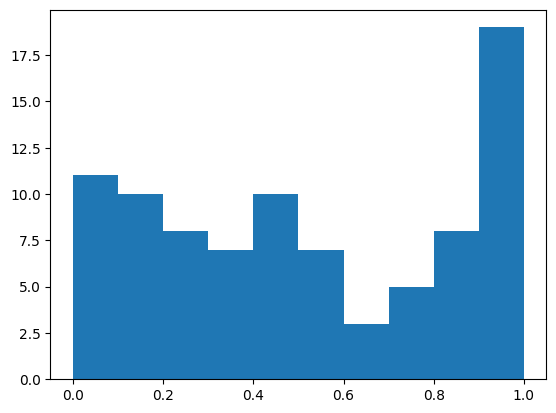

In [27]:
plt.hist(pval_df['p-valeur']);

In [28]:
# la p-valeur est égale à 1 quand on passe (quasiment) exactement autant de fois par un chemin que par l'autre
for i in range(len(pval_list)):
    if pval_list[i][0] == 1:
        print(table_contingence(pval_list[i][1]))

           g0  g1
>19>20>22  30  29
19>21>22   30  31
           g0  g1
25>27>28   35  35
>25>26>28  25  25
           g0  g1
>31>33>34  29  28
31>32>34   31  32
           g0  g1
43>44>46   21  21
>43>45>46  39  39
                 g0  g1
>84>85>86>88>89   3   3
>84>85>87>88>89   6   6
84>89            51  51
              g0  g1
116>118>119   30  30
>116>117>119  30  30
              g0  g1
>176>177>178  49  49
176>178       11  11
              g0  g1
181>182>184   52  51
>181>183>184   8   9
              g0  g1
184>185>187   45  46
>184>186>187  15  14
              g0  g1
>195>196>198  15  14
195>197>198   45  46
              g0  g1
198>199>201   46  47
>198>200>201  14  13
              g0  g1
239>240>242   46  46
>239>241>242  14  14
              g0  g1
>263>264>266  34  33
263>265>266   26  27
              g0  g1
269>270>272   53  52
>269>271>272   7   8
              g0  g1
331>333>334   43  43
>331>332>334  17  17
              g0  g1
334>335>337   51  51
>334>336>337   9

In [29]:
'''print(table_contingence(i))
print(table_contingence(i).sum(axis = 0))
print(contingence_pb[i]) 


print(len(snarl_index_somme_pas_ok))
print(snarl_index_somme_pas_ok)
for i in snarl_index_somme_pas_ok:
    if i in zero_dans_contingence_snarl:
        print(i)

print('--------------------')
print(contingence_pb[i])
print('####################')''';

In [30]:
big_pv = [(-np.log10(pval_list[i][0]), pval_list[i][1]) for i in range(len(pval_list)) if -np.log10(pval_list[i][0]) > 2]
print(big_pv)
print('79>84' in deux_zero_dans_contingence_snarl)
table_contingence('79>84') #avant c'était la plus grosse p-valeur mais il manquait le chemin 79>80>82>83>84 (un peu embêtant vu que times taken = 0)

[(2.624205309601664, '89>92'), (2.15176597063122, '170>173'), (3.1620872897202483, '242>245'), (4.743716244978902, '254>256'), (3.1902936329226557, '446>449')]
True


,g0,g1
>79>84,45,17
79>80>81>83>84,15,43
>79>80>82>83>84,0,0


In [31]:
# find the smallest pvalues and the associated snarls
# plus trop utilse cette cell
# utilisée à l'époque pour regarder si les résultats semblaient cohérents (avant de comparer avec la réalité)

for i in range(len(pval_df)):
    if pval_df['moinslog10pvaleur'].iloc[i] > 2:
    # if pval_df.index[i] == '446>449':
        # print(pval_df['moinslog10pvaleur'].iloc[i])
        print('##########', pval_df['moinslog10pvaleur'].iloc[i])
        print(table_contingence(pval_df.index[i]))

########## 2.624205309601664
           g0  g1
89>91>92   35  51
>89>90>92  25   9
########## 2.15176597063122
              g0  g1
>170>172>173   4  16
170>171>173   56  44
########## 3.1620872897202483
              g0  g1
242>243>245   47  28
>242>244>245  13  32
########## 4.743716244978902
             g0  g1
254>255>256  52  29
>254>256      8  31
########## 3.1902936329226557
              g0  g1
446>448>449   54  37
>446>447>449   6  23


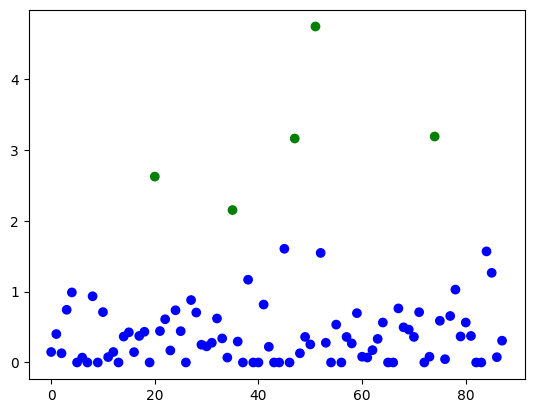

In [32]:
# manhattan plot

#fig = plt.figure(figsize=(14, 8)) 
#ax = fig.add_subplot(111)
plt.scatter(range(len(pval_df)), pval_df['moinslog10pvaleur'], c=pval_df['color'])
#ax.set_xlabel('snarl index')
#ax.set_ylabel('moins log10 pvalue')


In [ ]:
# snarl untrue ? donne des meilleurs noms à tes variables, yasmine
# ce sont les snarls passés à la trappe (donc avec des fréquences d'occurrence différentes (quand on regarde la vérité) mais qui n'ont pas été détectés par mon petit code) ET qui ne sont pas des snarls imbriqués 

snarl_untrue = ['198>201', '201>204', '427>438', '497>502']
for i in range(len(pval_df.index)):
    if pval_df.index[i] in snarl_untrue:
        print('##############', pval_df.index[i], ';',  pval_df['moinslog10pvaleur'].iloc[i])  
        print(table_contingence(pval_df.index[i]))
        
table_contingence('427>438')
        
# verdict : en théorie les probas de passage sont différentes mais en pratique c'est assez similaire et c'est pour ça que je ne les ai pas détectées pour trois des snarls et pour le quatrième je ne peux pas encore conclure parce qu'il y a des 0 dans la table de contingence


In [21]:
# on vérifie que la somme des colonnes dans les tables de contingence est toujours égale à 60

def contingence_somme_col(snarl_list):
    snarl_index_somme_pas_ok = []
    
    for i in snarl_list:
        if table_contingence(i).sum(axis = 0).iloc[0] != 60 or table_contingence(i).sum(axis = 0).iloc[1] != 60:
            snarl_index_somme_pas_ok.append(i)
    
    if len(snarl_index_somme_pas_ok) == 0:
        print('bien ouej !')
    else:
        print('better luck next time...')
        
contingence_somme_col(snarl_df.index.unique())

bien ouej !


In [ ]:
# trafiquer les tables de contingences 
## on ne veut plus de 0 dans les tables
## on veut pas changer les effectifs par colonnes !!

contingence_pb = [table_contingence(i) for i in zero_dans_contingence_snarl]
contingence_no_pb = copy.deepcopy(contingence_pb)

########## ce qui va pas ici c'est que le max prend -1 au lieu de prendre -n avec n le nb de 0 dans la table ##########
#for i in range(len(contingence_pb)):
#    contingence_pb[i] = contingence_pb[i].where(contingence_pb[i] != 0, contingence_pb[i]+1)
#    contingence_pb[i] = contingence_pb[i].where(contingence_pb[i] != contingence_pb[i].max().max(), contingence_pb[i]-1)


for t in contingence_no_pb:
    zro_ctr_g0 = 0
    zro_ctr_g1 = 0
    
    #test = contingence_pb[0]
    
    for i in range(len(t)):
        if t['g0'].iloc[i] == 0:
            zro_ctr_g0 += 1
        if t['g1'].iloc[i] == 0:
            zro_ctr_g1 += 1
    
    t.loc[t['g0'] == 0, 'g0'] = 1
    t.loc[t['g1'] == 0, 'g1'] = 1
    t.loc[t['g0'] == t.max().loc['g0'], 'g0'] = t.max().loc['g0'] - zro_ctr_g0
    t.loc[t['g1'] == t.max().loc['g1'], 'g1'] = t.max().loc['g1'] - zro_ctr_g1

contingence_somme_col(zero_dans_contingence_snarl)

contingence_pb[6]


In [ ]:
# on vérifie qu'il n'y a effectivement plus de 0 dans les tables de contingences et on calcule les p-valeurs (trafiquées) qu'on n'a pas pu calculer avant 
new_zero_dans_contingence_snarl = [] 
pval_pb = []
# désueulasse mais deux boucles for parce que le cas i = 6 est particulier et il faut que je réfléchisse à comment le gérer 
# en gros il y a tellement de 0 dans la matrice que quand on fait max-nb_zro ça fait un nb négatif 
for i in range(0, 6):
    if 0 not in contingence_no_pb[i]:
        pval_pb.append([chi2(contingence_no_pb[i]), i])
    else:
        #pval_list.append([-1, i])
        new_zero_dans_contingence_snarl.append(i)
        
for i in range(7, 17):
    if 0 not in contingence_no_pb[i]:
        pval_pb.append([chi2(contingence_no_pb[i]), i])
    else:
        #pval_list.append([-1, i])
        new_zero_dans_contingence_snarl.append(i)
print(len(new_zero_dans_contingence_snarl))
print(len(pval_pb))

In [ ]:
# pval_pb = [[chi2(i), 0] for i in contingence_pb] # pour l'instant je peux pas faire les choses élégamment à cause du cas i = 6 qui est ignoble 
'''for i in range(len(pval_pb)):
    pval_pb[i][1] = zero_dans_contingence_snarl[i]'''
pval_all = pval_list + pval_pb

pval_all_df = create_pval_df(pval_all)
for i in pval_all_df.index:
    if i not in pval_df.index:
        pval_all_df.loc[i, 'color'] = "yellow"
 
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
ax[0][0].hist(pval_df['p-valeur'])
ax[0][0].set_title('legal pvalues')
ax[0][1].hist(pval_all_df['p-valeur'])
ax[0][1].set_title('all pvalues')

ax[1][0].scatter(range(len(pval_df)), pval_df['moinslog10pvaleur'], c=pval_df['color'])
ax[1][0].set_title('legal moins log10 pvalues')
ax[1][1].scatter(range(len(pval_all_df)), pval_all_df['moinslog10pvaleur'], c=pval_all_df['color'])
ax[1][1].set_title('all moins log10 pvalues')
#plt.hist(pval_all)

In [ ]:
# proof (pour moi même) that the two df are not identical 
# par contre trafiquer les tables de contingences n'a pas permis d'avoir de petites pvaleurs 
print(len(pval_df), len(pval_all_df))

#c'est len de pvall_all_df qui est censée être égale à 100 ça veut dire qu'il y a 17 trucs en trop (voir def create pval_df) 

## la suite

In [ ]:
 # cb de snarls avec n chemins possibles ?
from itertools import groupby

length_of_paths = []
for i in list(snarl_df.index):
    length_of_paths.append(list(snarl_df.index).count(i))
    
# occ = [[x,ind.count(x)] for x in set(ind)]

taille_chem = list(set(length_of_paths))
freq_taille = [len(list(group)) for key, group in groupby(sorted(length_of_paths))]

print(taille_chem, freq_taille)

 # 'Play' with bdsg
##### am i playing with bdsg or is bdsg playing with me

In [ ]:
from bdsg.bdsg import HashGraph

gr = HashGraph()
seq = ["CGA", "TTGG", "CCGT", "C", "GT", "GATAA", "CGG", "ACA", "GCCG", "ATATAAC"]
n = []
for s in seq:
    n.append(gr.create_handle(s))

gr.create_edge(n[0], n[1])
gr.create_edge(n[1], n[2])
gr.create_edge(n[2], n[3])
gr.create_edge(n[2], n[4])
gr.create_edge(n[3], n[5])
gr.create_edge(n[5], n[6])
# Connect the end of n5 to the start of n8
gr.create_edge(n[5], n[8])
gr.create_edge(n[6], n[7])
gr.create_edge(n[6], n[8])
gr.create_edge(n[7], n[9])
gr.create_edge(n[8], n[9])
# Connect the end of n8 back around to the start of n5
gr.create_edge(n[8], n[5])

def next_node_list(handle):
    lis = []
    gr.follow_edges(handle, False, lambda y: lis.append(y))
    return lis

print(n)

print(f'n0: {gr.get_sequence(n[0])}')
next_node = next_node_list(n[0])[0]
print(f'n1: {gr.get_sequence(next_node)}')
next_node = next_node_list(next_node)[0]
print(f'n2: {gr.get_sequence(next_node)}')

path = gr.create_path_handle("path")
gr.append_step(path, n[0])
gr.append_step(path, n[1])
gr.append_step(path, n[2])
gr.append_step(path, n[4])
gr.append_step(path, n[5])
gr.append_step(path, n[6])
gr.append_step(path, n[7])
gr.append_step(path, n[9])

In [ ]:
from bdsg.bdsg import PackedGraph
brca2 = PackedGraph()
brca2.deserialize("/home/yboulkaid/Documents/sample_data/pgtest.data/pg.pg")
#brca2.deserialize("/home/yboulkaid/Téléchargements/cactus-brca2.pg")

path_handle = []
handles = []
brca2.for_each_path_handle(lambda y: path_handle.append(y) or True)
brca2.for_each_step_in_path(path_handle[0],
    lambda y: handles.append(brca2.get_handle_of_step(y)) or True)
sequence = ""
for handle in handles:
    sequence += brca2.get_sequence(handle)
print(sequence[0:10])
print(len(sequence))


In [ ]:
type(gr)

# CACGTCCGAGAATCGG
# CACGTCCGAG

In [ ]:
from bdsg.handlegraph import  HandleGraph
###########################################
### HOW TO ACCESS THE SNARL TREE (XIAN) ###
###########################################

# load the snarl tree
stree = bdsg.bdsg.SnarlDistanceIndex()
stree.deserialize("pg.dist")
# Note: make the pg.dist from the pg.pg using: vg index -j pg.dist pg.pg

# load the graph
pg = bdsg.bdsg.PackedGraph()
pg.deserialize("pg.pg")

## To practice let's save all the nodes in the snarl tree in a list
stnodes = []
# find the object pointing to the root of the snarl tree
root = distance_index.get_root()
# the function we want to run on each child of a snarl tree node
def save_snarl_tree_node(stnode):
    # FILL
    #   here for example, save the input in the list and iterate on its potential children
    # if the function returns True, the iteration will continue (which is what we want in this case)
    return(True)
# run that function, starting from the rood node of the tree
stree.for_each_child(root, save_snarl_tree_node)
# note: for_each_child can only be run on elements that have children (i.e. chains and snarls), not nodes or sentinels.

## Understanding elements of the snarl tree
# get one of the snarl tree nodes saved earlier
stn = stnodes[3]
# print it's "string" summary
stree.net_handle_as_string(stn)
# check which type it is
stree.is_chain(stn)
stree.is_snarl(stn)
stree.is_sentinel(stn)
stree.is_node(stn)

## Manipulating a snarl
# assuming we have a snarl, get the boundary nodes
stn_start = stree.get_bound(stn, False, True)
stn_end = stree.get_bound(stn, True, True)
# get the actual node, not the sentinel (~fake boundary nodes?)
stn_start = stree.get_node_from_sentinel(stn_start)
stn_end = stree.get_node_from_sentinel(stn_end)
stn_end = stree.flip(stn_end) # flip the end handle (I think, to be confirmed)
# get a node id
stree.node_id(stn_start)
# get a handle/object of that node in the graph
stn_start_pg = stree.get_handle(stn_start, pg)
stn_end_pg = stree.get_handle(stn_end, pg)
# get the ID of an element in the graph, here a node
pg.get_id(stn_start_pg)
# test if there is an edge between two nodes in the graph
pg.has_edge(stn_start_pg, stn_end_pg)


In [ ]:
print(ngraph)
print(distance_index.net_handle_as_string(ngraph['n'][0]))

In [ ]:
ngraph['n']

In [ ]:
distance_index.deserialize("/home/yboulkaid/Documents/sample_data/pgtest.data/pg.dist")

In [ ]:
'''get parent 
get child 
get bound 
get root'''